In [1]:
import os
import random
import csv
import numpy as np
from tqdm import tqdm
from gym import spaces
import matplotlib.patches as patches

from env.env_CRC import SpatOmics_dis
from src.dqn import DQN
from src.args import get_dqn_args

class Tester():
    def __init__(self, args, seed, categ, pos, target):
        self.args = args
        self.seed = seed
        self.categ = categ
        self.num = len(categ)
        self.pos = pos
        self.target = target
        model_folder = 'model'
        self.model_seed_folder = os.path.join(model_folder, 'DQN', f'seed_{self.seed}')
        # Create env
        id_exp = 0 # random.randint(0, self.num-1)
        self.env_test = SpatOmics_dis(self.args, self.categ[id_exp], self.pos[id_exp], self.target[id_exp])
        # observation and action spaces
        self.grid_x, self.grid_y = self.args.grid_x, self.args.grid_y
        n_obs = self.grid_x*self.grid_y*self.args.cell_num + 2 + 17
        self.observation_space = spaces.Box(low = -np.array(np.ones(n_obs)), high = np.array(np.ones(n_obs)), dtype=np.float64)
        self.action_space = spaces.Discrete(24)
        self.args.obs_dim = self.observation_space.shape[0]  # obs dimensions
        self.args.action_dim = self.action_space.n

        self.agent = DQN(self.args.obs_dim, self.args.action_dim, args)
        self.agent.load(self.seed, "best", self.model_seed_folder)
        print("env: {}".format(id_exp))

        self.total_steps = 0


    def make_folders(self):
        test_dir = './data/DQN/seed_{}/test'.format(self.seed)
        if not os.path.exists(test_dir):
            os.makedirs(test_dir)
        self.test_dir = test_dir
        test_fig_dir = test_dir + '/fig'
        if not os.path.exists(test_fig_dir):
            os.makedirs(test_fig_dir)
        self.test_fig_dir = test_fig_dir

    def test_policy(self, rand=False):
        evaluate_reward = 0
        episode_rewards = []
        self.total_steps = 0
        all_obses = []

        for _ in tqdm(range(1000), desc="Heatmap evaluating"):
            state = self.env_test.reset()
            episode_reward = 0
            obses = []
            AD_countses = []
            for _ in range(self.args.episode_size):
                action = self.agent.select_action(state, isEval=True)
                next_state, reward, _, _ = self.env_test.step(action, rand, isEval=True) 
                state = next_state
                episode_reward += reward
                AD_countses.append(episode_reward)
                obses.append([state[0], state[1], episode_reward])
                self.total_steps += 1

            evaluate_reward += episode_reward
            episode_rewards.append(episode_reward)
            all_obses.append(obses)


        all_obses = np.array(all_obses)
        print("========================================")
        if not rand:
            np.save('./data/DQN/seed_{}/test/all_obses.npy'.format(self.seed), all_obses)
            print("Evaluation: Total_steps:{} \t Fisher policy completed".format(self.total_steps))
            np.save('./data/DQN/seed_{}/test/test_episode_rewards.npy'.format(self.seed), episode_rewards)
        else:
            np.save('./data/DQN/seed_{}/test/all_obses_random.npy'.format(self.seed), all_obses)
            print("Evaluation: Total_steps:{} \t random policy completed".format(self.total_steps))
            np.save('./data/DQN/seed_{}/test/test_episode_rewards_random.npy'.format(self.seed), episode_rewards)
        print("========================================")
        

    def test_policy_steps(self, rand=False, steps=50):
        evaluate_reward = 0
        episode_rewards = []
        self.total_steps = 0
        all_obses = []

        for _ in tqdm(range(200), desc="Steps scatter evaluating"):
            state = self.env_test.reset()
            episode_reward = 0
            obses = []
            AD_countses = []
            for _ in range(steps):
                action = self.agent.select_action(state, isEval=True)
                next_state, reward, _, _ = self.env_test.step(action, rand, isEval=True) 
                state = next_state
                episode_reward += reward
                AD_countses.append(episode_reward)
                obses.append([state[0], state[1], episode_reward])
                self.total_steps += 1

            evaluate_reward += episode_reward
            episode_rewards.append(episode_reward)
            all_obses.append(obses)


        all_obses = np.array(all_obses)
        print("========================================")
        if not rand:
            np.save('./data/DQN/seed_{}/test/all_obses_{}.npy'.format(self.seed, steps), all_obses)
            print("Evaluation: Total_steps:{} \t {} steps Fisher policy completed".format(self.total_steps, steps))
            np.save('./data/DQN/seed_{}/test/test_episode_rewards_{}.npy'.format(self.seed, steps), episode_rewards)
        else:
            np.save('./data/DQN/seed_{}/test/all_obses_random_{}.npy'.format(self.seed, steps), all_obses)
            print("Evaluation: Total_steps:{} \t {} steps random policy completed".format(self.total_steps, steps))
            np.save('./data/DQN/seed_{}/test/test_episode_rewards_random_{}.npy'.format(self.seed, steps), episode_rewards)
        print("========================================")
        
    def test_policy_counts(self, rand=False):
        success_counts=[]
        first_counts=[]
        for _ in tqdm(range(1000), desc="Hits counts evaluating"):
            state = self.env_test.reset()
            r_AD_sum = 0
            for count in range(self.args.episode_size):
                action = self.agent.select_action(state, isEval=True) 
                next_state, reward, done, r_AD = self.env_test.step(action, rand, isEval=True)  # Step
                count += 1
                if (r_AD_sum == 0 and r_AD > 0) or (r_AD_sum == 0 and count == self.args.episode_size):
                    first_counts.append(count)
                r_AD_sum += r_AD
                state = next_state
                if r_AD_sum > 100 or count == self.args.episode_size:
                    success_counts.append(count)
                    break
        
        
        print("========================================")
        if not rand:
            np.save('./data/DQN/seed_{}/test/test_first_counts.npy'.format(self.seed), first_counts)
            np.save('./data/DQN/seed_{}/test/test_success_counts.npy'.format(self.seed), success_counts)
            print("Fisher policy completed")
        else:
            np.save('./data/DQN/seed_{}/test/test_first_counts_random.npy'.format(self.seed), first_counts)
            np.save('./data/DQN/seed_{}/test/test_success_counts_random.npy'.format(self.seed), success_counts)
            print("random policy completed")
        print("========================================")
        
    def test_policy_fig(self):
        evaluate_reward = 0
        evaluate_rewards=[]
        self.total_steps = 0
        for eval_time in range(self.args.evaluate_times):
            state = self.env_test.reset()
            episode_reward = 0
            obses = []
            AD_countses= []
            for _ in range(self.args.episode_size):
                action = self.agent.select_action(state, isEval=True) 
                next_state, reward, done, _ = self.env_test.step(action, rand=False)  # Step
                state = next_state
                episode_reward += reward
                AD_countses.append(episode_reward)
                obses.append(state[0:2])
                self.total_steps += 1
                if done:
                    break
            evaluate_reward += episode_reward
            evaluate_rewards.append(evaluate_reward)

            # visualize
            font1 = {'family' : 'Times New Roman','weight' : 'normal',}  #'size' : 12,}
            ## trajectory
            obses = np.array(obses)
            fig, ax = plt.subplots() 
            for center in obses:
                lower_left = (center[0] - self.env_test.rs/2, center[1] - self.env_test.rs/2)
                square = patches.Rectangle(lower_left, self.env_test.rs, self.env_test.rs, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(square)
            ax.plot(obses[:, 0], obses[:, 1], color='gray', linestyle='-', linewidth=1)
            ax.scatter(obses[:, 0], obses[:, 1], color='red')
            ax.scatter(obses[0, 0], obses[0, 1], color='blue', label='Start')
            ax.scatter(obses[-1, 0], obses[-1, 1], color='green', label='Final')
            ax.scatter(self.env_test.AD_pos[:, 0], self.env_test.AD_pos[:, 1], color='pink', label='target', s=5, marker='o')
            ax.set_aspect('equal', 'box')
            ax.autoscale()

            plt.xlabel('X (m)',font1)
            plt.ylabel('Y (m)',font1)
            plt.axis('equal')
            plt.xlim(self.env_test.x_min, self.env_test.x_max)
            plt.ylim(self.env_test.y_min, self.env_test.y_max)
            ax = plt.gca()
            labels = ax.get_xticklabels() + ax.get_yticklabels()
            [label.set_fontname('Times New Roman') for label in labels]
            plt.legend( prop = font1)
            plt.savefig('{}/sampling_{}.png'.format(self.test_fig_dir, eval_time + 1),  bbox_inches='tight')
            plt.close()
            np.save('./data/DQN/seed_{}/test/obses_{}.npy'.format(self.seed, eval_time+1),
                    obses)

        evaluate_reward = evaluate_reward / self.args.evaluate_times
        print("========================================")
        print("Evaluation: Total_steps:{} \t average_evaluate_reward:{}".format(self.total_steps, evaluate_reward))
        print("========================================")
        np.save('./data/DQN/seed_{}/test/ADs.npy'.format(self.seed),
                self.env_test.AD_pos)
        np.save('./data/DQN/seed_{}/test/rs.npy'.format(self.seed),
                self.env_test.rs)
        np.save('./data/DQN/seed_{}/test/x_min.npy'.format(self.seed),
                self.env_test.x_min)
        np.save('./data/DQN/seed_{}/test/x_max.npy'.format(self.seed),
                self.env_test.x_max)
        np.save('./data/DQN/seed_{}/test/y_min.npy'.format(self.seed),
                self.env_test.y_min)
        np.save('./data/DQN/seed_{}/test/y_max.npy'.format(self.seed),
                self.env_test.y_max)

In [2]:
args = get_dqn_args()

args.rs = 100
args.cell_num = 10

print("Start testing {} for Sampling in Spatial Omics".format(args.agent_name))


dataset = 'schurch2020coordinated'
exps = ['022_A']
seed = 123

categ, pos, target = [], [], []
for exp in exps:
    file_path = os.path.join('dataset_CRC', 'reg{}.csv'.format(exp))
    data_categ, data_pos, data_target = [], [], []
    with open(file_path, newline='') as csvfile:

        reader = csv.reader(csvfile)
        next(reader)
        for row in reader:
            temp = row[1:3]
            temp_num = [int(x) for x in temp]
            data_pos.append(temp_num)
            data_categ.append(row[0:1])
            data_target.append(row[3:4])
    pos.append(np.array(data_pos))
    categ.append(np.array(data_categ))
    target.append(np.array(data_target))


# create Tester
tester = Tester(args, seed, categ, pos, target)
tester.make_folders()

Start testing DQN for Sampling in Spatial Omics
env: 0


In [3]:
# test 1
tester.test_policy()
tester.test_policy(rand=True)

Heatmap evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]/home/ww/PycharmProjects/SOFisher/src/dqn.py:69: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/builder/cbouss/pytorch/croot/pytorch_1685629640362/work/torch/csrc/utils/tensor_new.cpp:230.)
  state = T.FloatTensor([observation]).to(device).unsqueeze(0)
Heatmap evaluating: 100%|██████████| 1000/1000 [01:20<00:00, 12.40it/s]


Evaluation: Total_steps:50000 	 Fisher policy completed


Heatmap evaluating: 100%|██████████| 1000/1000 [01:07<00:00, 14.76it/s]

Evaluation: Total_steps:50000 	 random policy completed


In [4]:
# test 2
for steps in [10, 20, 30, 40, 50]:
    tester.test_policy_steps(rand=False, steps=steps)
    tester.test_policy_steps(rand=True, steps=steps)

Steps scatter evaluating: 100%|██████████| 200/200 [00:03<00:00, 64.20it/s]


Evaluation: Total_steps:2000 	 10 steps Fisher policy completed


Steps scatter evaluating: 100%|██████████| 200/200 [00:02<00:00, 69.60it/s]


Evaluation: Total_steps:2000 	 10 steps random policy completed


Steps scatter evaluating: 100%|██████████| 200/200 [00:06<00:00, 30.84it/s]


Evaluation: Total_steps:4000 	 20 steps Fisher policy completed


Steps scatter evaluating: 100%|██████████| 200/200 [00:06<00:00, 32.70it/s]


Evaluation: Total_steps:4000 	 20 steps random policy completed


Steps scatter evaluating: 100%|██████████| 200/200 [00:10<00:00, 18.77it/s]


Evaluation: Total_steps:6000 	 30 steps Fisher policy completed


Steps scatter evaluating: 100%|██████████| 200/200 [00:08<00:00, 23.25it/s]


Evaluation: Total_steps:6000 	 30 steps random policy completed


Steps scatter evaluating: 100%|██████████| 200/200 [00:12<00:00, 15.61it/s]


Evaluation: Total_steps:8000 	 40 steps Fisher policy completed


Steps scatter evaluating: 100%|██████████| 200/200 [00:10<00:00, 18.49it/s]


Evaluation: Total_steps:8000 	 40 steps random policy completed


Steps scatter evaluating: 100%|██████████| 200/200 [00:15<00:00, 13.21it/s]


Evaluation: Total_steps:10000 	 50 steps Fisher policy completed


Steps scatter evaluating: 100%|██████████| 200/200 [00:13<00:00, 15.11it/s]

Evaluation: Total_steps:10000 	 50 steps random policy completed


In [5]:
# test 3    
tester.test_policy_counts()
tester.test_policy_counts(rand=True)

Hits counts evaluating: 100%|██████████| 1000/1000 [00:19<00:00, 50.72it/s]


Fisher policy completed


Hits counts evaluating: 100%|██████████| 1000/1000 [00:43<00:00, 22.83it/s]

random policy completed


In [6]:
import matplotlib.pyplot as plt

# test 4
tester.test_policy_fig()

Evaluation: Total_steps:50 	 average_evaluate_reward:-241.29000000000002


In [7]:
path = './data/DQN/seed_{}/test/'.format(seed)

all_obses = np.load(path + 'all_obses.npy')
all_obses_random = np.load(path + 'all_obses_random.npy')
ADs = np.load(path + 'ADs.npy')

In [8]:
x = np.load(path + 'test_episode_rewards.npy') / 5
y = np.load(path + 'test_episode_rewards_random.npy') / 5

In [9]:
first_counts = np.load(path + 'test_first_counts.npy')
success_counts = np.load(path + 'test_success_counts.npy')
first_counts_r = np.load(path + 'test_first_counts_random.npy')
success_counts_r = np.load(path + 'test_success_counts_random.npy')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


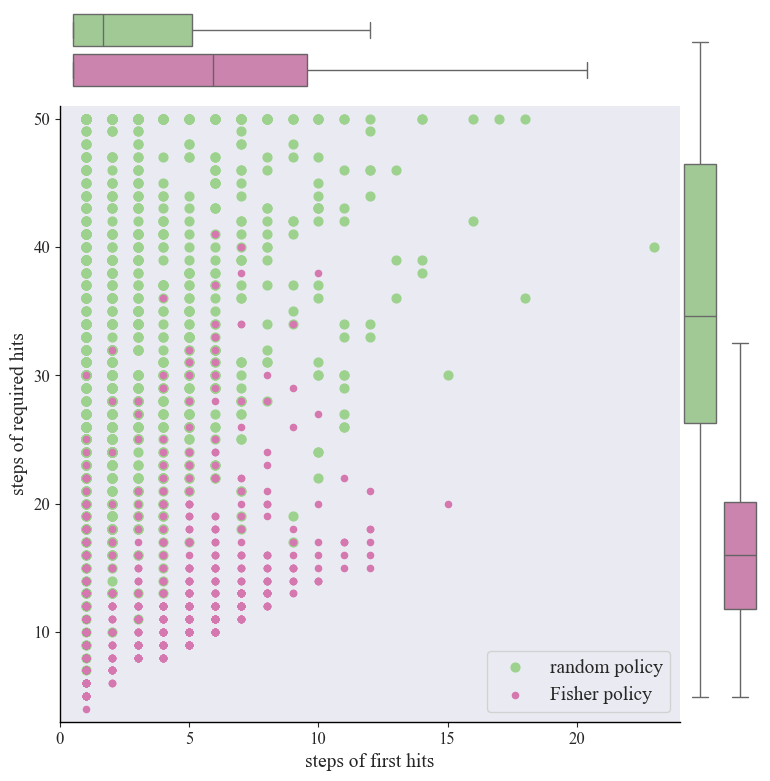

In [10]:
import seaborn as sns

# set font
font1 = {'family': 'Times New Roman', 'weight': 'normal', 'size': 14}

# create fig & ax
fig, main_ax = plt.subplots(figsize=(8, 8))

# without grid
main_ax.grid(False)

# set x y label
main_ax.set_xlabel('steps of first hits', font1)
main_ax.set_ylabel('steps of required hits', font1)

# scatter plot
main_ax.scatter(first_counts_r, success_counts_r, s=40, label='random policy', color='#9CD28D')
main_ax.scatter(first_counts, success_counts, s=20, label='Fisher policy', zorder=2, color='#D678B0')


# set legend
main_ax.legend(prop=font1)

# set tick label
labels = main_ax.get_xticklabels() + main_ax.get_yticklabels()
for label in labels:
    label.set_fontname('Times New Roman')
    label.set_fontsize(12)

# add box plot around x
x_box_r = fig.add_axes([0.1, 0.95, 0.9, 0.05], frame_on=False)
sns.boxplot(first_counts_r, ax=x_box_r, orient='h', color='#9CD28D', fliersize=0)
x_box_r.set(xticks=[], yticks=[])
x_box_r.set_facecolor('none')

x_box = fig.add_axes([0.1, 0.9, 0.9, 0.05], frame_on=False)
sns.boxplot(first_counts, ax=x_box, orient='h', color='#D678B0', fliersize=0)
x_box.set(xticks=[], yticks=[])
x_box.set_facecolor('none')


y_box_r = fig.add_axes([0.9, 0.1, 0.05, 0.9], frame_on=False)
sns.boxplot(success_counts_r, ax=y_box_r, orient='v', color='#9CD28D', fliersize=0)
y_box_r.set(xticks=[], yticks=[])
y_box_r.set_facecolor('none')

# add box plot around y
y_box = fig.add_axes([0.95, 0.1, 0.05, 0.9], frame_on=False)
sns.boxplot(success_counts, ax=y_box, orient='v', color='#D678B0', fliersize=0)
y_box.set(xticks=[], yticks=[])
y_box.set_facecolor('none')


# set range
main_ax.set_xlim([min(min(first_counts_r), min(first_counts)) - 1, max(max(first_counts_r), max(first_counts)) + 1])
main_ax.set_ylim([min(min(success_counts_r), min(success_counts)) - 1, max(max(success_counts_r), max(success_counts)) + 1])

# Show some spines
main_ax.spines['top'].set_visible(False)
main_ax.spines['right'].set_visible(False)
main_ax.spines['left'].set_visible(True)
main_ax.spines['bottom'].set_visible(True)

# set spines
main_ax.spines['left'].set_color('black')
main_ax.spines['bottom'].set_color('black')
main_ax.spines['left'].set_linewidth(1)
main_ax.spines['bottom'].set_linewidth(1)

# Customize tick parameters
main_ax.tick_params(left=True, bottom=True)

# save fig
plt.savefig(path + 'compare.pdf', transparent=True)
plt.savefig(path + 'compare.eps', transparent=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


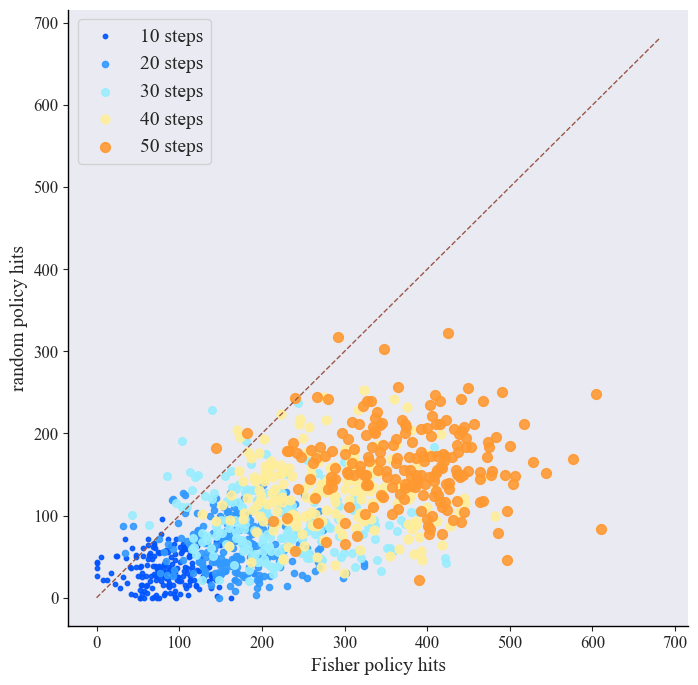

In [11]:
x_1 = np.load(path + 'test_episode_rewards_10.npy') / 5
x_2 = np.load(path + 'test_episode_rewards_20.npy') / 5
x_3 = np.load(path + 'test_episode_rewards_30.npy') / 5
x_4 = np.load(path + 'test_episode_rewards_40.npy') / 5
x_5 = np.load(path + 'test_episode_rewards_50.npy') / 5

y_1 = np.load(path + 'test_episode_rewards_random_10.npy') / 5
y_2 = np.load(path + 'test_episode_rewards_random_20.npy') / 5
y_3 = np.load(path + 'test_episode_rewards_random_30.npy') / 5
y_4 = np.load(path + 'test_episode_rewards_random_40.npy') / 5
y_5 = np.load(path + 'test_episode_rewards_random_50.npy') / 5


from palettable.lightbartlein.diverging import BlueOrange10_8

colors = BlueOrange10_8.mpl_colors


import matplotlib.pyplot as plt

# visualize
font1 = {'family': 'Times New Roman', 'weight': 'normal', 'size': 14} 

fig, ax = plt.subplots(figsize=(8, 8))

# no grid
ax.grid(False)

plt.xlabel('Fisher policy hits', font1)
plt.ylabel('random policy hits', font1)


ax = plt.gca()
labels = ax.get_xticklabels() + ax.get_yticklabels()
for label in labels:
    label.set_fontname('Times New Roman')
    label.set_fontsize(12)


plt.scatter(x_1, y_1, s=10, color=colors[0], label='10 steps', alpha=0.9)
plt.scatter(x_2, y_2, s=20, color=colors[1], label='20 steps', alpha=0.9)
plt.scatter(x_3, y_3, s=30, color=colors[2], label='30 steps', alpha=0.9)
plt.scatter(x_4, y_4, s=40, color=colors[5], label='40 steps', alpha=0.9)
plt.scatter(x_5, y_5, s=50, color=colors[6], label='50 steps', alpha=0.9)

line = np.linspace(0, max(x), 50)
plt.plot(line, line, color='#9A5747', linewidth=1, linestyle='--')


plt.legend(prop=font1)

# Show some spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# set spines
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

# Customize tick parameters
ax.tick_params(left=True, bottom=True)

ax.set_aspect('auto', 'box')

fig.savefig(path + 'scoreSS.eps', transparent=True)
fig.savefig(path + 'scoreSS.pdf', transparent=True)

In [12]:
import matplotlib.pyplot as plt

step = np.linspace(1, 50, 50)

avg1 = np.mean(all_obses_random[:, :, 2]/5, 0)
std1 = np.std(all_obses_random[:, :, 2]/5, 0)

avg = np.mean(all_obses[:, :, 2]/5, 0)
std = np.std(all_obses[:, :, 2]/5, 0)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


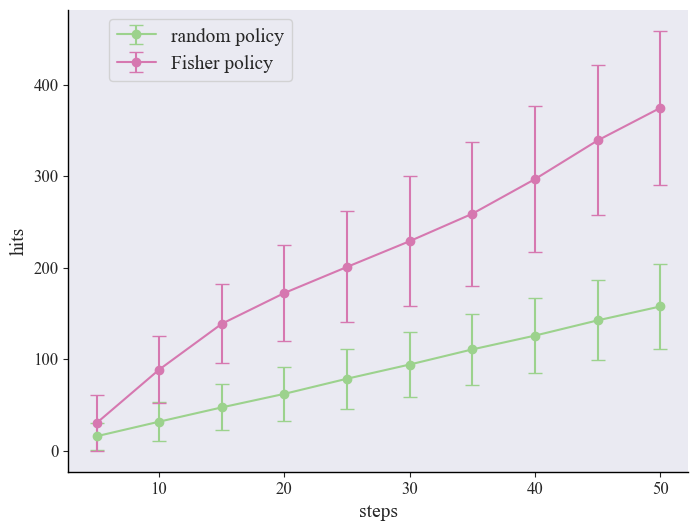

In [13]:
# visualize
font1 = {'family': 'Times New Roman', 'weight': 'normal', 'size': 14} 

fig, ax = plt.subplots(figsize=(8, 6))

# no grid
ax.grid(False)


plt.xlabel('steps', font1)
plt.ylabel('hits', font1)


ax = plt.gca()
labels = ax.get_xticklabels() + ax.get_yticklabels()
for label in labels:
    label.set_fontname('Times New Roman')
    label.set_fontsize(12)
# select indices: 5, 10, 15, ...
selected_indices = np.arange(4, 50, 5)

# select step
selected_step = step[selected_indices]
selected_avg1 = avg1[selected_indices]
selected_std1 = std1[selected_indices]
selected_avg = avg[selected_indices]
selected_std = std[selected_indices]


plt.errorbar(selected_step, selected_avg1, yerr=selected_std1, fmt='o-', capsize=5, label='random policy', color='#9CD28D')
plt.errorbar(selected_step, selected_avg, yerr=selected_std, fmt='o-', capsize=5, label='Fisher policy', color='#D678B0')


plt.legend(prop=font1, loc='upper left', bbox_to_anchor=(0.05, 1))

# Show some spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# set spines
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

# Customize tick parameters
ax.tick_params(left=True, bottom=True)

ax.set_aspect('auto', 'box')


fig.savefig(path + 'error_bar.eps', transparent=True)
fig.savefig(path + 'error_bar.pdf', transparent=True)

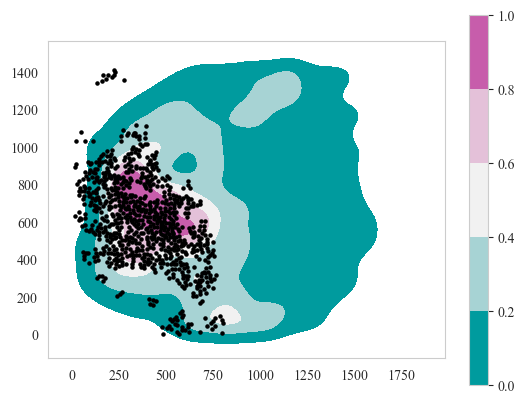

In [14]:
from palettable.cartocolors.diverging import Tropic_5
from matplotlib.colors import ListedColormap

tropic_5_cmap = ListedColormap(Tropic_5.mpl_colors)

import seaborn as sns

# Temporarily set seaborn style to include axis lines
with sns.axes_style("whitegrid"):
    font1 = {'family': 'Times New Roman', 'weight': 'normal'}

    fig, ax = plt.subplots()

    # no gird
    ax.grid(False)


    reshaped_obses = all_obses[:,:,:2].reshape(-1, 2)

    kde = sns.kdeplot(x=reshaped_obses[:,0], y=reshaped_obses[:,1], fill=True, cmap=tropic_5_cmap, ax=ax)
    ax.scatter(ADs[:, 0], ADs[:, 1], color='black', label='ABeta', s=5, marker='o')

    
    # set color bar cmap
    sm = plt.cm.ScalarMappable(cmap=tropic_5_cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    
    # set font
    labels = ax.get_xticklabels() + ax.get_yticklabels() + cbar.ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]

    # Set aspect ratio to 'auto' for automatic adjustment
    ax.set_aspect('equal', 'box')
    
    
    fig.savefig(path + 'heatmap.eps', transparent=True, bbox_inches='tight')
    fig.savefig(path + 'heatmap.pdf', transparent=True, bbox_inches='tight')

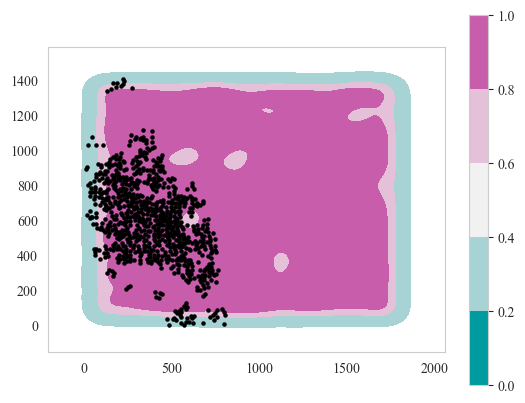

In [15]:
from palettable.cartocolors.diverging import Tropic_5
from matplotlib.colors import ListedColormap

tropic_5_cmap = ListedColormap(Tropic_5.mpl_colors)

import seaborn as sns

# Temporarily set seaborn style to include axis lines
with sns.axes_style("whitegrid"):
    font1 = {'family': 'Times New Roman', 'weight': 'normal'}

    fig, ax = plt.subplots()

    # no grid
    ax.grid(False)


    reshaped_obses = all_obses_random[:,:,:2].reshape(-1, 2)

    kde = sns.kdeplot(x=reshaped_obses[:,0], y=reshaped_obses[:,1], fill=True, cmap=tropic_5_cmap, ax=ax)
    ax.scatter(ADs[:, 0], ADs[:, 1], color='black', label='ABeta', s=5, marker='o')

    
    # set color bar cmap
    sm = plt.cm.ScalarMappable(cmap=tropic_5_cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    
    # set font
    labels = ax.get_xticklabels() + ax.get_yticklabels() + cbar.ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]

    # Set aspect ratio to 'auto' for automatic adjustment
    ax.set_aspect('equal', 'box')
    
    
    fig.savefig(path + 'heatmap_random.eps', transparent=True, bbox_inches='tight')
    fig.savefig(path + 'heatmap_random.pdf', transparent=True, bbox_inches='tight')